In [1]:
%reload_ext autoreload
%autoreload 2

"""Much of this code from the excellent https://github.com/higgsfield/RL-Adventure"""
import math, random
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


import seaborn as sns


import sys
if "../../" not in sys.path:
  sys.path.append("../../") 



import collections
import torch.nn as nn

from  collections  import deque
%matplotlib inline

from IPython.display import clear_output

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [2]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. 
                                                                * frame_idx / epsilon_decay)

In [4]:
class Market(gym.Env):
    def __init__(self, kappa, episodes, time_periods, mu, r, sigma, inv_range):

        self.episodes = episodes
        self.time_periods = time_periods
        self.epi = 0
        self.t = 0

        self.inv_range = inv_range

        self.mu = mu
        self.r = r
        self.sigma = sigma

        self._start_wealth = 100.0
        self.kappa = kappa

        self.action_space = spaces.Discrete(len(inv_range))
        self.observation_space = spaces.Box(0,120, np.array([2]))
        
        self.seed()
        self.viewer = None
        self.state = None

        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self.S, self.B, self.dS, self.dB = self.generate_price_series()
        self.wealth = self._start_wealth
        #self.state = (int(self.S[self.t,self.epi]*100),int(self._start_wealth/10))
        
        self.state = (self.S[self.t,self.epi],self._start_wealth)
        return np.array(self.state)

    
    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        price_state, wealth_state = self.state
        
        prop = self.inv_range[action]

        discount = 0.99

        if self.t < self.time_periods:
            NB = (1-prop)*self.wealth/self.B[self.t]
            NS = prop*self.wealth/self.S[self.t, self.epi]

            dX = NB*self.dB[self.t] +NS*self.dS[self.t,self.epi]
            reward = dX - (self.kappa/2)*(dX**2)  
            
            self.wealth += dX
            #log_reward = np.log(1+dX/self.wealth)

            done = False

            #self.wealth_state = int(self.wealth/10)
            self.wealth_state = self.wealth
            self.t += 1
            
            #new_state = (int(self.S[self.t,self.epi]*100), self.wealth_state)
            
            new_state = (self.S[self.t,self.epi], self.wealth_state)
            self.state = new_state
            final_wealth = 0.0
            
        else:
            #reached the end of episode...
            self.t = 0
            self.epi = 0 #+=1

            reward = 0.0
            dX = 0.0
            final_wealth = self.wealth
            done = True

            _ = self.reset()

        return np.array(self.state), reward, done, final_wealth

    def generate_price_series(self):
        I = 1 #self.episodes
        M = self.time_periods

        S0 = 1
        B0 = 1
        T = 1.0
        dt = T/M

        mu = self.mu
        r = self.r
        sigma = self.sigma

        S = np.zeros((M+1,I))
        dS = np.zeros((M,I))
        dB = np.zeros(M)

        B = np.zeros(M+1)
        B[0] = B0
        S[0] = S0

        for t in range(1, M+1):
            #z = np.random.standard_normal(I)
            df = 10
            z = np.random.standard_t(df,I)
            S[t] = S[t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*z)
            B[t] = B[t-1]*np.exp(r*dt)

        for t in range(1,M):
            dS[t] = S[t+1] - S[t]
            dB[t] = B[t+1] - B[t]

        return S, B, dS, dB

In [5]:
kappa = 0.005
episodes = 30001
time_periods = 250
mu =0.122
rf = 0.0477
sigma = 0.1698

In [7]:
episodes = episodes #500k worked well? as did 1m

utes = 21
u_star = np.linspace(0,5, utes)

Mark = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star) #parameters from earlier

In [8]:
u_star

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [9]:
env = Mark

In [10]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
            #print(action)
            #print('nromal')
        else:
            action = random.randrange(env.action_space.n)
            #print('rand')
        return action

In [11]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [12]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [13]:
update_target(current_model, target_model)

In [14]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [15]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [16]:
def plot2(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

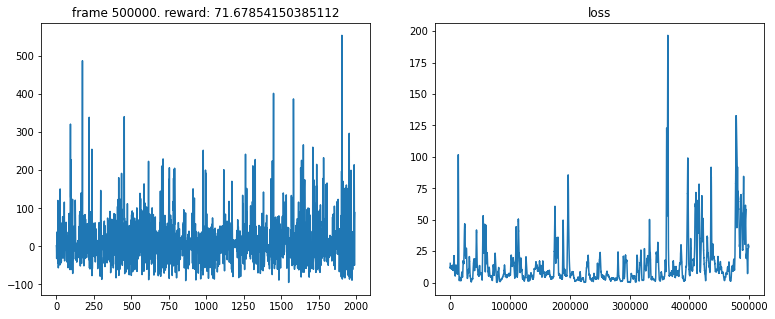

In [17]:
num_frames = 500000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
#all_actions=[]

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    
    action = current_model.act(state, epsilon) #norm
    
    #print(action)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        #all_actions.append(action)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        #print('here')
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
    if frame_idx % 400 == 0:
        plot(frame_idx, all_rewards
                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)


In [18]:
#helper function to give keras like model summary
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict


def summary(model, input_size, device="cuda"):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                if isinstance(output, (list,tuple)):
                    summary[m_key]['output_shape'] = [[-1] + list(o.size())[1:] for o in output]
                else:
                    summary[m_key]['output_shape'] = list(output.size())
                    summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight') and hasattr(module.weight, 'size'):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]['trainable'] = module.weight.requires_grad
                if hasattr(module, 'bias') and hasattr(module.bias, 'size'):
                    params +=  torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if (not isinstance(module, nn.Sequential) and 
               not isinstance(module, nn.ModuleList) and 
               not (module == model)):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in ["cuda", "cpu"], "Input device is not valid, please specify 'cuda' or 'cpu'"

        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(torch.rand(2,*in_size)).type(dtype) for in_size in input_size]
        else:
            x = Variable(torch.rand(2,*input_size)).type(dtype)
            
            
        # print(type(x[0]))
        # create properties
        summary = OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        # print(x.shape)
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        print('----------------------------------------------------------------')
        line_new = '{:>20}  {:>25} {:>15}'.format('Layer (type)', 'Output Shape', 'Param #')
        print(line_new)
        print('================================================================')
        total_params = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = '{:>20}  {:>25} {:>15}'.format(layer, str(summary[layer]['output_shape']), '{0:,}'.format(summary[layer]['nb_params']))
            total_params += summary[layer]['nb_params']
            if 'trainable' in summary[layer]:
                if summary[layer]['trainable'] == True:
                    trainable_params += summary[layer]['nb_params']
            print(line_new)
        print('================================================================')
        print('Total params: {0:,}'.format(total_params))
        print('Trainable params: {0:,}'.format(trainable_params))
        print('Non-trainable params: {0:,}'.format(total_params - trainable_params))
        print('----------------------------------------------------------------')
        # return summary

In [21]:

summary(current_model,[2,])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 26]           1,690
Total params: 6,042
Trainable params: 6,042
Non-trainable params: 0
----------------------------------------------------------------


In [19]:
episodes = 100001
wealth = 100.0
gamma=0.99
utilities_mod = []
rewards_mod = []
step_rewards = []
rsum = 0
wealth_episodes = []
number_of_actions = utes

Mark1 = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star)


for i_episode in range(episodes-1):

    if i_episode%1000 ==0:
        print(i_episode)
        
    state = Mark1.reset() 
    action = current_model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

    while True:    
        new_state , reward, done, final_wealth = Mark1.step(action) #(prop, wealth))
        action = current_model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
        rsum += reward
        #log_rsum += log_reward 
        state = new_state

        #print(new_state)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        step_rewards.append(reward)

        if done:
            wealth_episodes.append(final_wealth)
            utilities_mod.append(np.log(final_wealth))
            rewards_mod.append(rsum)
            #log_rewards_mod.append(log_rsum)
            rsum = 0
            #log_rsum = 0
            #wealth = 100.0
            #print(i_episode, final_wealth)
            break 


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [23]:
from lib.sim_prices2 import make_prices2
from lib.execute_strat2 import execute_strat2
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step

In [35]:
def make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test, 
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test,
                     step_rewards_best, step_rewards_rand, step_rewards_test):
    
    block_utilities_test = np.mean(np.array(utilities_test).reshape(500,-1),0)
    block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(500,-1),0)
    block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(500,-1),0)


    block_wealth_test_rand = np.mean(np.array(wealth_test_rand).reshape(500,-1),0)
    block_wealth_test_best = np.mean(np.array(wealth_test_best).reshape(500,-1),0)
    block_wealth_test = np.mean(np.array(wealth_test).reshape(500,-1),0)

    
    block_rewards_test = np.mean(np.array(rewards_test).reshape(500,-1),0)
    block_rewards_test_rand = np.mean(np.array(rewards_test_rand).reshape(500,-1),0)
    block_rewards_test_best = np.mean(np.array(rewards_test_best).reshape(500,-1),0)

    #Calculate sharpe ratios instead of longitudinally do it at the end blocks of 1000 again

    #mu - rf/ sigma


    wr = np.array(step_rewards_rand).reshape(10040,-1)
    wr_sharpe = (wr.mean(axis=0))/(wr.std(axis=0))
    wr_sortino = (wr.mean(axis=0))/(wr[wr<0].std(axis=0))

    wt = np.array(step_rewards_test).reshape(10040,-1)
    wt_sharpe = (wt.mean(axis=0))/(wt.std(axis=0))
    wt_sortino = (wt.mean(axis=0))/(wt[wt<0].std(axis=0))

    wb = np.array(step_rewards_best).reshape(10040,-1)
    wb_sharpe = (wb.mean(axis=0))/(wb.std(axis=0))
    wb_sortino = (wb.mean(axis=0))/(wb[wb<0].std(axis=0))


    sns.distplot(block_rewards_test_best, label="Merton optimal")
    sns.distplot(block_rewards_test, label="Trained Agent")
    sns.distplot(block_rewards_test_rand, label="Random agent")
    #plt.title('Distribution of Final rewards Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('MV utility')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_rewards_test_rand, block_rewards_test, block_rewards_test_best])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("MV utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Rewards - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_utilities_test_best, label="Merton optimal")
    sns.distplot(block_utilities_test, label="Trained Agent")
    sns.distplot(block_utilities_test_rand, label="Random agent")
    #plt.title('Distribution of Final log utilities Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('log utility')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    plt.violinplot([block_utilities_test_rand, block_utilities_test, block_utilities_test_best])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("log utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of utilities - Random v Merton v Agent")
    plt.show()
    
    plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    #plt.title('Moving average 10000 episode log utilities')
    plt.ylabel('log utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.plot(np.convolve(rewards_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(rewards_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(rewards_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    #plt.title('Moving average 10000 episode MV rewards')
    plt.ylabel('MV utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.plot(np.convolve(wealth_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(wealth_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(wealth_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    #plt.title('Moving average 10000 episode wealth')
    plt.ylabel('Wealth')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.violinplot([block_wealth_test_rand, block_wealth_test, block_wealth_test_best])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("Wealth", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Wealth - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_wealth_test_best, label="Merton optimal")
    sns.distplot(block_wealth_test, label="Trained Agent")
    sns.distplot(block_wealth_test_rand, label="Random agent")
    #plt.title('Distribution of Final Wealth Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('Wealth')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sharpe, wt_sharpe, wb_sharpe])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("Sharpe ratio", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Sharpe ratios - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sharpe, label="Merton optimal")
    sns.distplot(wt_sharpe, label="Trained Agent")
    sns.distplot(wr_sharpe, label="Random agent")
    #plt.title('Distribution of Final Sharpe ratios  Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('Sharpe ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sortino, wt_sortino, wb_sortino])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("Sortino ratio", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Sortino ratios - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sortino, label="Merton optimal")
    sns.distplot(wt_sortino, label="Trained Agent")
    sns.distplot(wr_sortino, label="Random agent")
    #plt.title('Distribution of Final Sortino ratios  Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('Sortino ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return block_utilities_test_rand, block_utilities_test, block_utilities_test_best, \
           block_rewards_test_rand, block_rewards_test, block_rewards_test_best, \
           block_wealth_test_rand, block_wealth_test, block_wealth_test_best, \
           wr_sharpe, wt_sharpe, wb_sharpe, wr_sortino, wt_sortino, wb_sortino

In [38]:
def make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test, 
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test,
                     step_rewards_best, step_rewards_rand, step_rewards_test,
                     rf):
    
    block_utilities_test = np.mean(np.array(utilities_test).reshape(500,-1),0)
    block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(500,-1),0)
    block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(500,-1),0)


    block_wealth_test_rand = np.mean(np.array(wealth_test_rand).reshape(500,-1),0)
    block_wealth_test_best = np.mean(np.array(wealth_test_best).reshape(500,-1),0)
    block_wealth_test = np.mean(np.array(wealth_test).reshape(500,-1),0)

    
    block_rewards_test = np.mean(np.array(rewards_test).reshape(500,-1),0)
    block_rewards_test_rand = np.mean(np.array(rewards_test_rand).reshape(500,-1),0)
    block_rewards_test_best = np.mean(np.array(rewards_test_best).reshape(500,-1),0)

    #Calculate sharpe ratios instead of longitudinally do it at the end blocks of 1000 again

    """#mu - rf/ sigma


    wr = np.array(step_rewards_rand).reshape(10040,-1)
    wr_sharpe = (wr.mean(axis=0))/(wr.std(axis=0))
    wr_sortino = (wr.mean(axis=0))/(wr[wr<0].std(axis=0))

    wt = np.array(step_rewards_test).reshape(10040,-1)
    wt_sharpe = (wt.mean(axis=0))/(wt.std(axis=0))
    wt_sortino = (wt.mean(axis=0))/(wt[wt<0].std(axis=0))

    wb = np.array(step_rewards_best).reshape(10040,-1)
    wb_sharpe = (wb.mean(axis=0))/(wb.std(axis=0))
    wb_sortino = (wb.mean(axis=0))/(wb[wb<0].std(axis=0))"""

    #mu - rf/ sigma
    wr = np.array(wealth_test_rand).reshape(500,-1)
    wr_sharpe = (wr.mean(axis=0)-100-rf*100)/(wr.std(axis=0))
    wr_sortino = (wr.mean(axis=0)-100-rf*100)/(wr[wr-100-100*rf<0].std(axis=0))

    wt = np.array(wealth_test).reshape(500,-1)
    wt_sharpe = (wt.mean(axis=0)-100-rf*100)/(wt.std(axis=0))
    wt_sortino = (wt.mean(axis=0)-100-rf*100)/(wt[wt-100-100*rf<0].std(axis=0))

    wb = np.array(wealth_test_best).reshape(500,-1)
    wb_sharpe = (wb.mean(axis=0)-100-rf*100)/(wb.std(axis=0))
    wb_sortino = (wb.mean(axis=0)-100-rf*100)/(wb[wb-100-100*rf<0].std(axis=0))

    sns.distplot(block_rewards_test_best, label="Merton optimal")
    sns.distplot(block_rewards_test, label="Trained Agent")
    sns.distplot(block_rewards_test_rand, label="Random agent")
    #plt.title('Distribution of Final rewards Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('MV utility')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_rewards_test_rand, block_rewards_test, block_rewards_test_best])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("MV utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Rewards - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_utilities_test_best, label="Merton optimal")
    sns.distplot(block_utilities_test, label="Trained Agent")
    sns.distplot(block_utilities_test_rand, label="Random agent")
    #plt.title('Distribution of Final log utilities Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('log utility')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    plt.violinplot([block_utilities_test_rand, block_utilities_test, block_utilities_test_best])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("log utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of utilities - Random v Merton v Agent")
    plt.show()
    
    plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    #plt.title('Moving average 10000 episode log utilities')
    plt.ylabel('log utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.plot(np.convolve(rewards_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(rewards_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(rewards_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    #plt.title('Moving average 10000 episode MV rewards')
    plt.ylabel('MV utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.plot(np.convolve(wealth_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(wealth_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(wealth_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    #plt.title('Moving average 10000 episode wealth')
    plt.ylabel('Wealth')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.violinplot([block_wealth_test_rand, block_wealth_test, block_wealth_test_best])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("Wealth", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Wealth - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_wealth_test_best, label="Merton optimal")
    sns.distplot(block_wealth_test, label="Trained Agent")
    sns.distplot(block_wealth_test_rand, label="Random agent")
    #plt.title('Distribution of Final Wealth Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('Wealth')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sharpe, wt_sharpe, wb_sharpe])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("Sharpe ratio", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Sharpe ratios - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sharpe, label="Merton optimal")
    sns.distplot(wt_sharpe, label="Trained Agent")
    sns.distplot(wr_sharpe, label="Random agent")
    #plt.title('Distribution of Final Sharpe ratios  Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('Sharpe ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sortino, wt_sortino, wb_sortino])
    plt.xticks([1,2,3], ["Random", "Trained", "Merton"], size=12)
    plt.ylabel("Sortino ratio", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    #plt.title("Violin plot of Sortino ratios - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sortino, label="Merton optimal")
    sns.distplot(wt_sortino, label="Trained Agent")
    sns.distplot(wr_sortino, label="Random agent")
    #plt.title('Distribution of Final Sortino ratios  Merton v Trained Agent v Random (per 500 episodes)')
    plt.xlabel('Sortino ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return block_utilities_test_rand, block_utilities_test, block_utilities_test_best, \
           block_rewards_test_rand, block_rewards_test, block_rewards_test_best, \
           block_wealth_test_rand, block_wealth_test, block_wealth_test_best, \
           wr_sharpe, wt_sharpe, wb_sharpe, wr_sortino, wt_sortino, wb_sortino

In [34]:
wealth = 100.0

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#temp change to execute strat
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat2(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random',
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best= execute_strat2(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)

In [22]:
utilities_test = utilities_mod
rewards_test = rewards_mod
step_rew_test = step_rewards
wealth_test = wealth_episodes

In [29]:
from statistics import mean, stdev
import pandas as pd

In [36]:
log_util_rand = mean(utilities_test_rand)
mv_util_rand = mean(rewards_test_rand)
wealth_rand = mean(wealth_test_rand)
excess_ret_rand = mean(wealth_test_rand)-100-100*rf
std_wealth = stdev(wealth_test_rand)
neg_std_wealth = stdev(list(filter(lambda x: x<0, [x-100-rf*100 for x in wealth_test_rand])))

rand_log_list=['Random',
log_util_rand, 
mv_util_rand, 
100*excess_ret_rand/std_wealth,
100*excess_ret_rand/neg_std_wealth,
wealth_rand]

log_util_best = mean(utilities_test_best)
mv_util_best = mean(rewards_test_best)
wealth_best = mean(wealth_test_best)
excess_ret_best = mean(wealth_test_best)-100-100*rf
std_wealth = stdev(wealth_test_best)
neg_std_wealth = stdev(list(filter(lambda x: x<0, [x-100-rf*100 for x in wealth_test_best])))

best_log_list=['Merton',
log_util_best, 
mv_util_best, 
100*excess_ret_best/std_wealth,
100*excess_ret_best/neg_std_wealth,
wealth_best]

model_results=pd.DataFrame({'model':['Q-learning']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]    
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]

#sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
avg_list.append(mean(utilities_test))
mv_util.append(mean(rewards_test))
#avg_step_list.append(mean(step_rew_test))
#std_step_list.append(stdev(all_models_1[i][2]))
#negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
sharpe_list.append(100*mean([x-100-rf*100 for x in wealth_test])/stdev(wealth_test))
wealth_list.append(mean(wealth_test))
sortino_list.append(100*mean([x-100-rf*100 for x in wealth_test])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in wealth_test]))))
#plt.legend()
#plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

model_results.loc[1] = rand_log_list
model_results.loc[2] = best_log_list
print(model_results.round(3).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &       model &  log utility &  MV utility &  Sharpe &  Sortino &   Wealth \\
\midrule
0 &  Q-learning &        4.731 &      19.547 &  34.831 &  129.223 &  129.897 \\
1 &      Random &        4.695 &      15.917 &  29.852 &  112.464 &  127.673 \\
2 &      Merton &        4.735 &      19.052 &  35.500 &  123.169 &  127.201 \\
\bottomrule
\end{tabular}



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

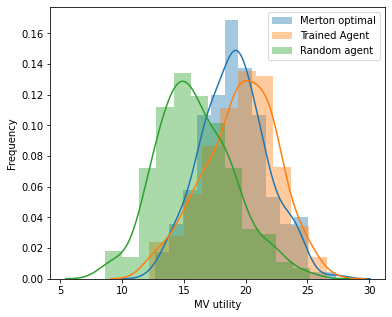

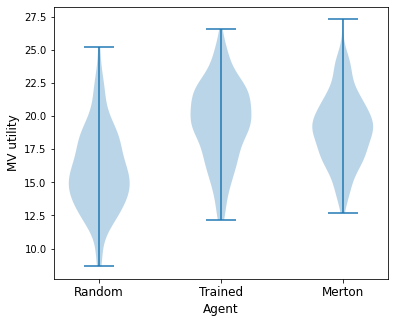

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

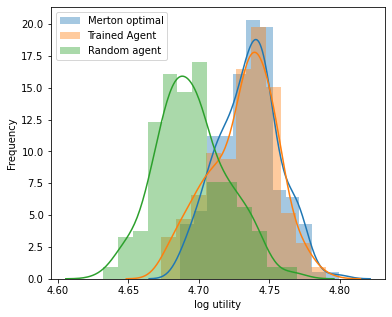

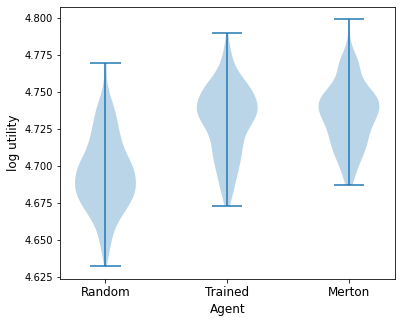

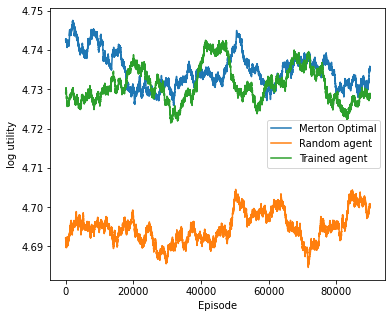

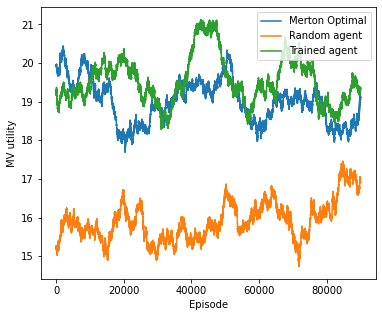

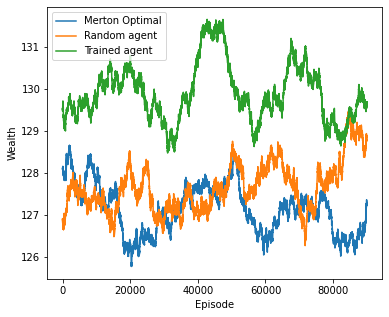

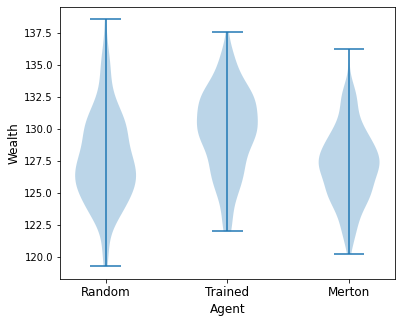

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

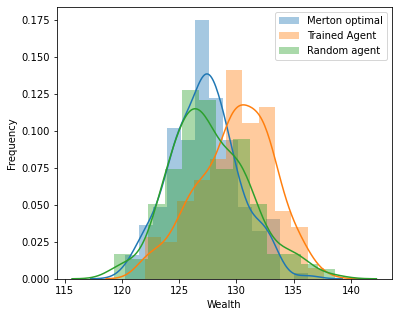

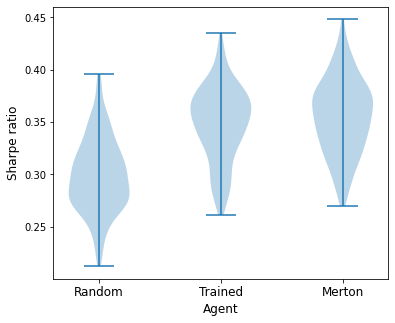

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

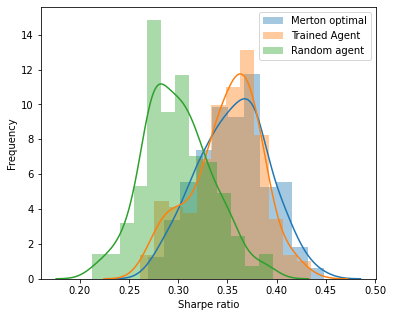

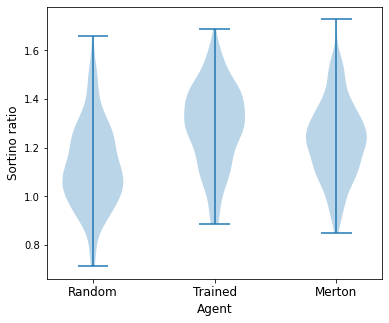

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

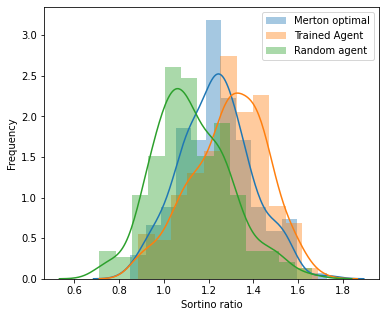

In [40]:
#utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
#                                                            'Agent', q_values=Q, 
#                                                            time_periods=time_periods, wealth=wealth)
plt.rcParams["figure.figsize"] = (6,5)
results = make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test, 
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test,
                     step_rew_best, step_rew_rand, step_rew_test,
                     rf)

In [45]:
import pandas as pd
from pandas_datareader import data as wb

class Market(gym.Env):
    def __init__(self, kappa, episodes, r, sigma, inv_range, start, end, ticker):

        self.episodes = episodes
        self.time_periods = time_periods
        self.epi = 0
        self.t = 0

        self.inv_range = inv_range
        self.start=start
        self.end=end
        self.ticker=ticker
        self.data=self.ticker_data()
        self.time_periods = len(self.data)-1
        self.mu = mu
        self.r = r
        self.sigma = sigma

        self._start_wealth = 100.0
        self.kappa = kappa

        self.action_space = spaces.Discrete(len(inv_range))
        self.observation_space = spaces.Box(0,120, np.array([2]))
        
        self.seed()
        self.viewer = None
        self.state = None
        self.data=self.ticker_data()
        self.time_periods = len(self.data)-1
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def ticker_data(self):
        data = pd.DataFrame(wb.DataReader(self.ticker, data_source = 'yahoo', start = self.start, end=self.end)['Adj Close'])
        return data

    def reset(self):
        self.S, self.B, self.dS, self.dB = self.generate_price_series()
        self.wealth = self._start_wealth
        #self.state = (int(self.S[self.t,self.epi]*100),int(self._start_wealth/10))
        
        self.state = (self.S[self.t,self.epi],self._start_wealth)
        return np.array(self.state)

    
    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        price_state, wealth_state = self.state
        
        prop = self.inv_range[action]

        discount = 0.99

        if self.t < self.time_periods:
            NB = (1-prop)*self.wealth/self.B[self.t]
            NS = prop*self.wealth/self.S[self.t, self.epi]

            dX = NB*self.dB[self.t] +NS*self.dS[self.t,self.epi]
            reward = dX - (self.kappa/2)*(dX**2)  
            self.wealth += dX

            done = False

            #self.wealth_state = int(self.wealth/10)
            self.wealth_state = self.wealth
            self.t += 1
            
            #new_state = (int(self.S[self.t,self.epi]*100), self.wealth_state)
            
            new_state = (self.S[self.t,self.epi], self.wealth_state)
            self.state = new_state
            final_wealth = 0.0
            
        else:
            #reached the end of episode...
            self.t = 0
            self.epi = 0 #+=1

            reward = 0.0
            dX = 0.0
            final_wealth = self.wealth
            done = True

            _ = self.reset()

        return np.array(self.state), reward, done, final_wealth,dX

    def generate_price_series(self):
        I = self.episodes
        M = self.time_periods
        data = self.data
        S0 = 1
        B0 = 1
        T = 1.0
        dt = T/M
        
        #mu = self.mu
        r = self.r
        #sigma = self.sigma
        
        S = np.zeros((M+1,I))
        dS = np.zeros((M,I))
        dB = np.zeros(M)

        B = np.zeros(M+1)
        B[0] = B0
        S[0] = S0
        
        for t in range(1, M+1):
            #z = np.random.standard_normal(I)
            #df = 10
            #z = np.random.standard_t(df,I)
            S[t] = float((data/float(data.iloc[0])).iloc[t])
            B[t] = B[t-1]*np.exp(r*dt)

        for t in range(1,M):
            dS[t] = S[t+1] - S[t]
            dB[t] = B[t+1] - B[t]

        #utility[i] = np.mean(np.log(X[-1,:]))
        #means[i] = np.mean(X[-1,:])
        #variances[i] = np.var(X[-1,:])
        return S, B, dS, dB

In [46]:
def d_execute_strat(start, end,ticker='SPY'):
    episodes = 2
    wealth = 100.0
    utilities_mod = []
    rewards_mod = []
    step_rewards = []
    step_wealth = []
    rsum = 0
    wealth_episodes = []
    number_of_actions = utes
    Mark1 = Market(kappa, episodes, rf, sigma, u_star, start, end,ticker)


    for i_episode in range(episodes-1):

        if i_episode%1 ==0:
            print(i_episode)
            
        state = Mark1.reset() 
        action = current_model.act(state,epsilon)
        #action = model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

        while True:    
            new_state , reward, done, final_wealth, dX = Mark1.step(action) #(prop, wealth))
            #action = model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
            action = current_model.act(state, epsilon)
            rsum += reward
            state = new_state

            #print(new_state)
            #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
            step_rewards.append(reward)
            step_wealth.append(dX)
            if done:
                wealth_episodes.append(final_wealth)
                utilities_mod.append(np.log(final_wealth))
                rewards_mod.append(rsum)
                rsum = 0
                #wealth = 100.0
                #print(i_episode, final_wealth)
                break 
    return utilities_mod, rewards_mod, step_rewards, wealth_episodes, step_wealth

In [47]:
import pandas as pd
from pandas_datareader import data as wb

In [42]:
period_1=d_execute_strat('2014-01-01','2015-12-31')
%store period_1
period_2=d_execute_strat('2016-01-01','2017-12-31')
%store period_2
period_3=d_execute_strat('2018-01-01','2019-12-31')
%store period_3
period_4=d_execute_strat('2020-01-01','2021-12-31')
%store period_4

0


/var/folders/zd/cn0gjphn5bbbfhg3clf82yyc0000gp/T/ipykernel_1226/3603700233.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


Stored 'period_1' (tuple)
0
Stored 'period_2' (tuple)
0
Stored 'period_3' (tuple)
0
Stored 'period_4' (tuple)


In [43]:
period_5=d_execute_strat('2014-01-01','2021-12-31')
%store period_5

0


/var/folders/zd/cn0gjphn5bbbfhg3clf82yyc0000gp/T/ipykernel_1226/3603700233.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


Stored 'period_5' (tuple)


In [44]:
period_6=d_execute_strat('2021-01-01','2021-12-31')
%store period_6

0
Stored 'period_6' (tuple)


/var/folders/zd/cn0gjphn5bbbfhg3clf82yyc0000gp/T/ipykernel_1226/3603700233.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [84]:
d_vgk=d_execute_strat('2021-01-01','2021-12-31', ticker='VGK')
%store d_vgk

0


/var/folders/zd/cn0gjphn5bbbfhg3clf82yyc0000gp/T/ipykernel_1226/3603700233.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


Stored 'd_vgk' (tuple)


In [49]:
d_oney=d_execute_strat('2021-01-01','2021-12-31', ticker='ONEY')
%store d_oney
d_qqq=d_execute_strat('2021-01-01','2021-12-31', ticker='QQQ')
%store d_qqq
d_wip=d_execute_strat('2021-01-01','2021-12-31', ticker='WIP')
%store d_wip
d_dia=d_execute_strat('2021-01-01','2021-12-31', ticker='DIA')
%store d_dia


0
Stored 'd_oney' (tuple)


/var/folders/zd/cn0gjphn5bbbfhg3clf82yyc0000gp/T/ipykernel_1226/3603700233.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


0
Stored 'd_qqq' (tuple)
0
Stored 'd_wip' (tuple)
0
Stored 'd_dia' (tuple)


In [92]:
ticker_list=list(pd.read_csv('/Users/madsrefer/Desktop/Specialeprojekt/Python/Thesis/MRes-Thesis/RL/nasdaq_screener.csv').Symbol)


['AAPL',
 'ABBV',
 'AMZN',
 'ASML',
 'AVGO',
 'AZN',
 'BABA',
 'BAC',
 'BRK/A',
 'BRK/B',
 'COST',
 'CSCO',
 'CVX',
 'GEN',
 'GOOG',
 'GOOGL',
 'HD',
 'JNJ',
 'JPM',
 'KO',
 'LLY',
 'MA',
 'MCD',
 'META',
 'MRK',
 'MSFT',
 'NVDA',
 'NVO',
 'ORCL',
 'PEP',
 'PFE',
 'PG',
 'SHEL',
 'TMO',
 'TSLA',
 'TSM',
 'UNH',
 'V',
 'WMT',
 'XOM']

In [100]:
d_naqdag_list=[]
for i in ticker_list:
    d_naqdag_list.append(d_execute_strat('2021-01-01','2021-12-31', ticker=i))


0


/var/folders/zd/cn0gjphn5bbbfhg3clf82yyc0000gp/T/ipykernel_1226/3603700233.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [101]:
%store d_naqdag_list

Stored 'd_naqdag_list' (list)
